# Imports

In [1]:
import numpy as np, os
if not [int(i) for i in np.__version__.split('.')] >= [1,20,1]: # check numpy version
    print('Upgrading numpy and stopping RUNTIME! When the notebook completes, please run again.')
    ! pip install --upgrade numpy    # suggested by Efosa, see also https://github.com/jswhit/pygrib/issues/192
    os.kill(os.getpid(), 9)          # kill the runtime, need to run again from the beginning! pip install pygrib
! pip install pygrib   
from grib_file import GribFile     # Martin's utility layer on top of  pygrib,from wrfxpy

## Kalman filter

The Kalman filter provides an estimate $u$ of the time evolution of some unknown process, called "nature" or "truth". We do not know with certainty what the nature is, but we can observe it at regular intervals (steps) with some error. In each step, model $F$ advances the model state $u$ in time, $ u \leftarrow F(u)$, and attempts to reconcile the state with an observation $d$ of the true state, so $u \approx d$. The filter modifies the model state $u$ to balance the uncertainty in the model and the data (this is called *analysis*) and the cycle continues. For that purpose, the filter evolves also an estimate of the uncertainly of the model.

More generally, instead of $u \approx d$, only a part of the state is observed, and $Hu \approx d$ where $H$ is a matrix, or observation function. Basically, $Hu$ is what the data would be if the model was completely accurate. 

In [2]:
import numpy as np
def ext_kf(u,P,F,Q=0,d=None,H=None,R=None):
  """
  One step of the extended Kalman filter. 
  If there is no data, only advance in time.
  :param u:   the state vector, shape n
  :param P:   the state covariance, shape (n,n)
  :param F:   the model function, args vector u, returns F(u) and Jacobian J(u)
  :param Q:   the process model noise covariance, shape (n,n)
  :param d:   data vector, shape (m). If none, only advance in time
  :param H:   observation matrix, shape (m,n)
  :param R:   data error covariance, shape (n,n)
  :return ua: the analysis state vector, shape (n)
  :return Pa: the analysis covariance matrix, shape (n,n)
  """
  def d2(a):
    return np.atleast_2d(a) # convert to at least 2d array

  def d1(a):
    return np.atleast_1d(a) # convert to at least 1d array

  # forecast
  uf, J  = F(u)          # advance the model state in time and get the Jacobian
  uf = d1(uf)            # if scalar, make state a 1D array
  J = d2(J)              # if scalar, make jacobian a 2D array
  P = d2(P)              # if scalar, make Jacobian as 2D array
  Pf  = d2(J.T @ P) @ J + Q  # advance the state covariance Pf = J' * P * J + Q
  # analysis
  if d is None or not d.size :  # no data, no analysis
    return uf, Pf
  # K = P H' * inverse(H * P * H' + R) = (inverse(H * P * H' + R)*(H P))'
  H = d2(H)
  HP  = d2(H @ P)            # precompute a part used twice  
  K   = d2(np.linalg.solve( d2(HP @ H.T) + R, HP)).T  # Kalman gain
  # print('H',H)
  # print('K',K)
  res = d1(H @ d1(uf) - d)          # res = H*uf - d
  ua = uf - K @ res # analysis mean uf - K*res
  Pa = Pf - K @ d2(H @ P)        # analysis covariance
  return ua, d2(Pa)


##  A basic exponential decay model of fuel moisture




The evolution of fuel moisture content $m(t)$ is modeled by the differential equation on interval $\left[
t_{0},t_{1}\right]  $,
$$
\frac{dm}{dt}=\frac{E-m(t)}{T},\quad m(t_{0})=m_{0}.
$$
where the initial fuel moisture content $m_{0}=m\left(  t_{0}\right)  $ is the
input, and $m_{1}=m(t_{1})$ is the output. Tnus, $m_1=F(m_0)$. The parameters of the model are the
fuel moisture equilibrium $E$, assumed to be constant over the interval $\left[
t_{0},t_{1}\right]  $, NS the characteristic decay time $T$. 

We can build the general model later by calling this simple model with different
equilibria and time constants (drying, wetting, rain).

Since $E$ is constant in time, the solution can be found
analytically,
$$
m\left(  t\right)  =E+\left(  m_{0}-E\right)  e^{-t/T}%
$$
For convenience, we use $T_{1}=1/T$ instead of $T$, and the model becomes
$$
m_{1}=E+\left(  m_{0}-E\right)  e^{-\left(  t_{1}-t_{0}\right)  T_{1}}%
$$
In the extended Kalman filter, we will need the partial derivatives of $m_{1}$
with respect to the input and the parameters. Compute
$$
\frac{dm_{1}}{d_{m0}}=e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dE}=1-e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dT_{1}}=-\left(  m_{0}-E\right)  \left(  t_{1}-t_{0}\right)
e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
At the moment, we need only ${dm_{1}}/{dm_{0}}$ but we put in the code all partials for possible use in future.


In [3]:
import numpy as np
def model_decay(m0,E,partials=0,T1=0.1,tlen=1):  
  # Arguments: 
  #   m0          fuel moisture content at start dimensionless, unit (1)
  #   E           fuel moisture eqilibrium (1)
  #   partials=0: return m1 = fuel moisture contents after time tlen (1)
  #           =1: return m1, dm0/dm0 
  #           =2: return m1, dm1/dm0, dm1/dE
  #           =3: return m1, dm1/dm0, dm1/dE dm1/dT1   
  #   T1          1/T, where T is the time constant approaching the equilibrium
  #               default 0.1/hour
  #   tlen        the time interval length, default 1 hour

  exp_t = np.exp(-tlen*T1)                  # compute this subexpression only once
  m1 = E + (m0 - E)*exp_t                   # the solution at end
  if partials==0:
    return m1
  dm1_dm0 = exp_t
  if partials==1:
    return m1, dm1_dm0          # return value and Jacobian
  dm1_dE = 1 - exp_t      
  if partials==2:
     return m1, dm1_dm0, dm1_dE 
  dm1_dT1 = -(m0 - E)*tlen*exp_t            # partial derivative dm1 / dT1
  if partials==3:
    return m1, dm1_dm0, dm1_dE, dm1_dT1       # return value and all partial derivatives wrt m1 and parameters
  raise('Bad arg partials')
  

## Kalman filter demonstration

We demonstrate the Kalman filter for this model on a simple artificial example. The model is solving the differential equation for one hour. The equilibrium $E$ is constant during the hour, but it changes over the day so that it is higher at night and lower during the day, with a 24-hour period.  First, we create the "truth" by choosing the equilibrium $E$ and solving the differential aquation every hour, with a small additive noise. The synthetic data is obtained as values of the "truth", with random noise to simulate observation error.

### Create synthetic data

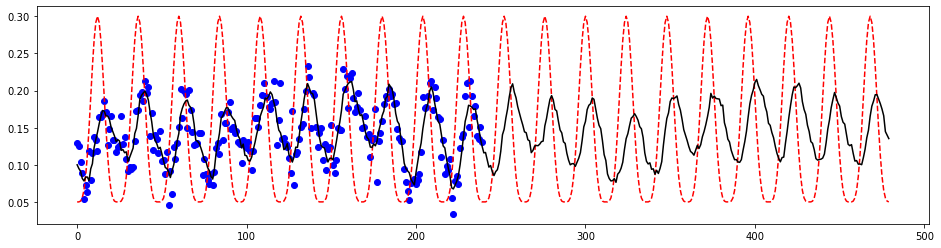

In [4]:
import numpy as np, random
days = 20       
hours = days*24
h2 = int(hours/2)
hour = range(hours)
day = np.array(range(hours))/24.

# artificial equilibrium data
E = np.power(np.sin(np.pi*day),4) # diurnal curve
E = 0.05+0.25*E
# FMC free run
m_f = np.zeros(hours)
m_f[0] = 0.1         # initial FMC
for t in range(hours-1):
  m_f[t+1] = max(0.,model_decay(m_f[t],E[t])  + random.gauss(0,0.005) )
data = m_f + np.random.normal(loc=0,scale=0.02,size=hours)    

%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize=(16,4))
plt.plot(hour,E,linestyle='--',c='r',label='Equilibrium')
plt.plot(hour,m_f,linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(hour[:h2],data[:h2],c='b',label='10-h fuel data')
 

### Run Kalman filter

We have used the same code for model and for the truth, and run the Kalman filter for 10 days. The graph below shows that the model state was remarkably close to the truth, even if the model is fed only noisy observations. This is because the dynamics of the model and of the truth are the same. After 10 days, we let the model continue without any new data to simulate forecasting the future, and the agreement with the truth was still very good.

In [5]:
import numpy as np
import matplotlib.pyplot as plt 

def kf_example(DeltaE):
  h2 = int(hours/2)
  m = np.zeros(hours)
  m[0]=0.1             # background state  
  P = np.zeros(hours)
  P[0] = 0.03 # background state variance
  Q = np.array([0.02]) # process noise variance
  H = np.array([1.])   # all observed
  R = np.array([0.02]) # data variance

  for t in range(h2):
    # use lambda construction to pass additional arguments to the model 
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)
  for t in range(h2,hours - 1):
    m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_decay(u,E[t]+DeltaE,partials=1))
  
  %matplotlib inline
  plt.figure(figsize=(16,4))
  plt.plot(hour,E,linestyle='--',c='r',label='Equilibrium')
  print(len(hour),len(m_f))
  plt.plot(hour,m_f,linestyle='-',c='b',label='10-h fuel truth')
  plt.scatter(hour[:h2],data[:h2],c='b',label='10-h fuel data')
  plt.plot(hour[:h2],m[:h2],linestyle='-',c='k',label='filtered')
  plt.plot(hour[h2:hours],m[h2:hours],linestyle='-',c='r',label='filtered')
  return E, P

480 480


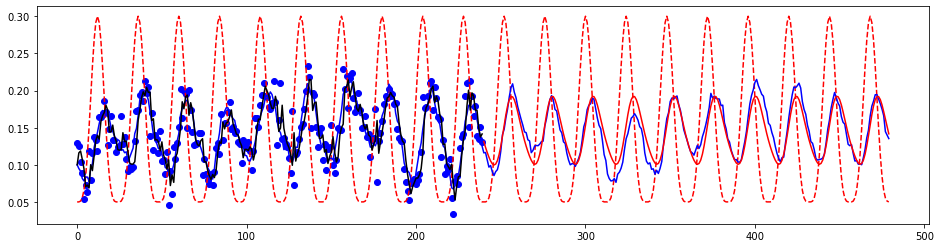

In [6]:
DeltaE = 0.0          # bias
E, P = kf_example(DeltaE)

In [7]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


We have recovered the fuel moisture from data with random noise - we **filtered** the noise out. 

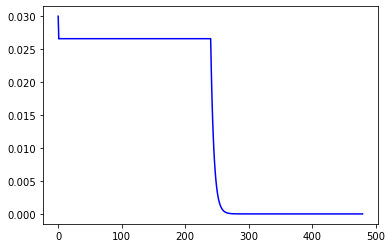

In [8]:
%matplotlib inline
plt.figure() # new figure
plt.plot(P,linestyle='-',c='b',label='Estimated state variance P')

Now what if the model is wrong - different from nature? That is always so in reality. Now suppose that the model and the truth are not the same. That is always the case in reality.  Consider a simple case when the model thinks that the equilibrium $E$ is too high.

480 480


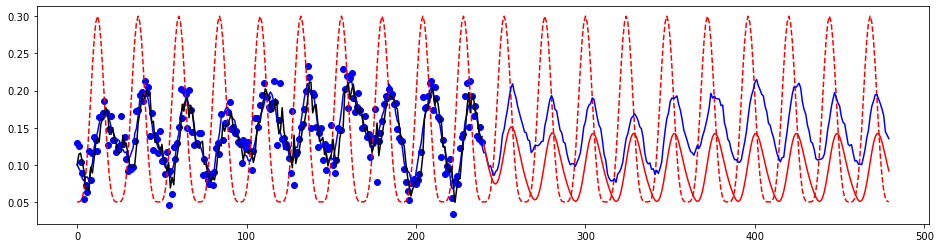

In [9]:
DeltaE = -0.05
E, P = kf_example(DeltaE)  

We have found a good estimate of the state $m$, while data is available. Also, the estimated state variance $P$ converges with time - we have *learned* the variance that balances the noise. But for forecasting fuel moisture, we need to continue the fuel moisture model into the future, and we can't have any measurements from future. We only have the equilibrium from weather forecast. And the forecast and the truth disagree - as soon as there is no data to attract the simulation, the model is doing its own thing.

## Real data

### Fuel moisture RAWS data

Try to load the data from a saved file first. If that fails, retrieve the fuel moisture data from sensors on weather stations in the Mesowest network. Get all stations with fuel moisture data in a spatial box within one hour, then pick one station and retrieve the whole time series.

In [10]:
import json
jfile = 'raws.json'
try:
    ! wget --no-clobber https://raw.githubusercontent.com/janmandel/notebooks/main/raws.json
    j = json.load(open(jfile,'r'))
    print('loaded from ',jfile)
    # Take the first station in the boulding box that has data between time_start and time_s2.
    # Then retrieve data for that station between time_start and time_end
    time_start = j['time_start']      # start of data time series
    # time_s2    = j['time_s2']         # end of segment to read coordinates
    time_end  = j['time_end']         # end of data time series
    meso_ts  = j['meso_ts']           # get meso observations time series
    obs_lon =   j['obs_lon']          # where we retrieved observations
    obs_lat =   j['obs_lat']
except:
    print("can't read",jfile,', creating')
    # set up bounds
    time_start = "201806010800"  # June 1 2018 08:00 in format yyyymmddHHMM
    time_s2    = "201806010900"  # June 1 2018 09:00 in format yyyymmddHHMM 
    time_end   = "201906200900"  # Nov 1 2018 09:00 in format yyyymmddHHMM 
    #time_start=  "201810230100"
    #time_s2=  "201810230300"
    #time_end  =  "201806022300"
    !pip install MesoPy
    from MesoPy import Meso
    bounding_box = "-115, 38, -110, 40"  # min longtitude, latitude
    meso_token="b40cb52cbdef43ef81329b84e8fd874f"       # you should get your own if you do more of this
    m = Meso(meso_token)# create a Meso object
    print('reading MesoWest fuel moisture data from',)
    meso_obss = m.timeseries(time_start, time_s2, bbox=bounding_box, 
                             showemptystations = '0', vars='fuel_moisture')   # ask the object for data
    # pick one station and retrieve the whole time series.
    station=meso_obss['STATION'][0]
    #print(json.dumps(station, indent=4))
    lon,lat = (float(station['LONGITUDE']),float(station['LATITUDE']))
    print(station['NAME'],'station',station['STID'],'at',lon,lat)
    e = 0.01   # tolerance
    bb = '%s, %s, %s, %s' % (lon - e, lat - e, lon + e, lat + e)
    print('bounding box',bb)
    meso_ts = m.timeseries(time_start, time_end, bbox=bb, showemptystations = '0', vars='fuel_moisture')   # ask the object for data
    obs_lon, obs_lat = (lon, lat)   # remember station coordinates for later
    j={'time_start':time_start,'time_s2':time_s2,'time_end':time_end,
       'meso_ts':meso_ts,'obs_lon':obs_lon,'obs_lat':obs_lat}
    json.dump(j,open(jfile,'w'),indent=4)
    print('done')

File ‘raws.json’ already there; not retrieving.

loaded from  raws.json


Text(0.5, 1.0, 'BKCU1 10 h fuel moisture data')

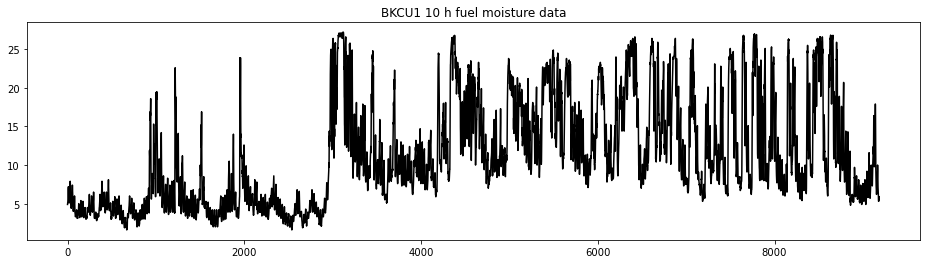

In [11]:
# process the data retrieved for this station
# print(json.dumps(meso_ts['STATION'][0], indent=4))
from datetime import datetime, timedelta, time
import numpy as np
import matplotlib.pyplot as plt
import pytz
station = meso_ts['STATION'][0]
time_str  = station['OBSERVATIONS']['date_time']
obs_time = [datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=pytz.UTC) for t in time_str]
start_time = obs_time[0].replace(minute=0)     # remember obs_time and start_time for later
end_time = obs_time[-1]
obs_data = np.array(station['OBSERVATIONS']["fuel_moisture_set_1"])
# display the data retrieved
#for o_time,o_data in zip (obs_time,obs_data):
#    print(o_time,o_data)
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(obs_data,linestyle='-',c='k',label='10-h fuel data')
plt.title(station['STID'] + ' 10 h fuel moisture data')

## Retrieve weather analysis for the duration of the station data, from our RTMA stash.

Create a function to transfer RTMA files in GRIB2 format from the stash. The function returns zero if the file transfer succeeded. If the file is not available, it returns a nonzero value. Note: if needed, maybe in future add more sophisticated checks, check the return code of wget and if the file size is correct.

In [12]:
import subprocess,os
def load_rtma(path,file,reload=0):
  url='http://math.ucdenver.edu/~jmandel/rtma/' + path 
  if os.path.exists(file):
    if reload:
      print(file + ' already exists, removing')
      os.remove(file)
    else:
      print(file + ' already exists, exiting')
      # add checking size here
      return 0
  try:
    ret = subprocess.check_output(['wget','--no-clobber','--output-document='+ file, url,],stderr=subprocess.STDOUT).decode() # execute command from python strings
    if os.path.exists(file):
      print('loaded ' + url + ' as ' + file)
      return 0
    else: 
      print('file transfer completed, but the file is missing? ' + url)  
      return 1
  except:
    print('file transfer failed: ' + url)
    return 2


Next, functions to get the files, open as grib, and interpolate to the station coordinates

In [13]:
def rtma_grib(t,var):
    tpath = '%4i%02i%02i/%02i' % (t.year, t.month, t.day, t.hour)  # remote path on server
    tstr  = '%4i%02i%02i%02i_' % (t.year, t.month, t.day, t.hour)  # time string for local path
    gribfile = os.path.join('data',tstr + var + '.grib')
    remote = tpath + '/' + var + '.grib'
    if load_rtma(remote,gribfile):
        print('cannot load remote file',remote,'as',gribfile)
        return []
    else:
        try:
            gf=GribFile(gribfile)
            v = np.array(gf[1].values())
        except:
            print('cannot read grib file',gribfile)
            return []
        print('loaded ',gribfile,' containing array shape ',v.shape)
        return gf[1]   # grib message


In [14]:
from scipy.interpolate import LinearNDInterpolator, interpn
from scipy.optimize import root
def interp_to_lat_lon_slow(lats,lons,v,lat,lon): 
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    interp=LinearNDInterpolator(list(zip(lats.flatten(),lons.flatten())),v.flatten())
    return interp(lat,lon)
def interp_to_lat_lon(lats,lons,v,lat,lon):
    # on mesh with coordinates lats and lons interpolate v to given lat lon
    points=(np.array(range(lats.shape[0]),float),np.array(range(lats.shape[1]),float))  # uniform mesh
    def res(ij):  # interpolation of lons lats on the uniform mesh, to noninteger coordinates   
       return np.hstack((interpn(points,lats,ij)-lat, interpn(points,lons,ij)-lon))
    # solve for xi,xj such that lats(xi,xj)=lat lons(xi,xj)=lon, then interpolate to (xi, xj) on uniform grid 
    result = root(res,(0,0)) # solve res(ij) = 0
    if not result.success:
        print(result.message)
        exit(1)
    return interpn(points,v,result.x) 


The interpolation function needs to  be tested.

In [15]:
def interp_to_lat_lon_test(lats,lons):
    print('testing interp_to_lat_lon')
    vx, vy = np.meshgrid(range(lats.shape[0]),range(lats.shape[1]),indexing='ij')
    i, j = (1,2)
    lat,lon = ((lats[i,j]+lats[i+1,j+1])/2,(lons[i,j]+lons[i+1,j+1])/2)
    vi = interp_to_lat_lon(lats,lons,vx,lat,lon)
    vj = interp_to_lat_lon(lats,lons,vy,lat,lon)
    print(vi,vj,'should be about',i+0.5,j+0.5)
    test_slow = 0
    if test_slow:
        print('Testing against the standard slow method scipy.interpolate.LinearNDInterpolator. Please wait...')
        vi_slow = interp_to_lat_lon_slow(lats,lons,vx,lat,lon)
        print(vi_slow)
        vj_slow = interp_to_lat_lon_slow(lats,lons,vy,lat,lon)
        print(vj_slow)
        
#gf = rtma_grib(start_time,'temp')      #  read the first grib file and use it to test interpolation
#lats, lons = gf.latlons()
#interp_to_lat_lon_test(lats,lons)


In [16]:
#%debug


Now we are ready for a function to read the RTMA files and interpolate to the station coordinates

In [17]:
import pandas as pd, json
def read_interp_rtma(varnames,times,lat,lon):
    # read RTMA from start_time to end_time and interpolate to obs_lat obs_lon
    ntimes = len(times)
    time_str = 'time_str'
    j={time_str:times.strftime('%Y-%m-%d %H:%M').tolist()}
    for varname in varnames:
        j[varname]=np.full(ntimes,np.nan)  # initialize array of nans as list
    n=0
    for t in times:
        tim=t.strftime('%Y-%m-%d %H:%M')
        should_be = j[time_str][n]
        if tim != should_be:
            print('n=',n,'time',tim,'expected',should_be)
            raise 'Invalid time' 
        for varname in varnames:
            gf = rtma_grib(t,varname)   # read and create grib object, download if needed
            if gf:
                lats,lons = gf.latlons()    # coordinates
                v = gf.values()
                vi=interp_to_lat_lon(lats,lons,v,lat,lon) # append to array
                print(varname,'at',t,'interpolated to',lat,lon,' value ',vi)
                j[varname][n] = vi
            else:
                print(varname,'at',t,' could not be loaded')
        n = n+1
    return j

In [18]:
import json
jfile = 'rtma.json'
try:
    j = json.load(open(jfile,'r'))
    print('loaded from ',jfile)
    if j['obs_lat']!=obs_lat or j['obs_lon']!=obs_lon:
        raise 'Wrong lon lat'
except:
    print("can't read",jfile,', creating')
    # Set up environment to read RTMA gribs
    # we will need current numpy for pygrib - needed on Colab, tensorflow is using numpy 1.19\
    times = pd.date_range(start=time_start,end=time_end,freq='1H')
    varnames=['temp','td','precipa']
    j =    read_interp_rtma(varnames,times,obs_lat,obs_lon)      # temperature
    for varname in varnames:
        j[varname]=j[varname].tolist() 
    j['obs_lat']=obs_lat
    j['obs_lon']=obs_lon
    json.dump(j,open('rtma.json','w'),indent=4)
    print('done')

loaded from  rtma.json


In [19]:
# %debug


In [20]:
rtma = j
td = np.array(rtma['td'])
t2 = np.array(rtma['temp'])
rain=np.array(rtma['precipa'])
# compute relative humidity
rh = 100*np.exp(17.625*243.04*(td - t2) / (243.04 + t2 - 273.15) / (243.0 + td - 273.15))
Ed = 0.924*rh**0.679 + 0.000499*np.exp(0.1*rh) + 0.18*(21.1 + 273.15 - t2)*(1 - np.exp(-0.115*rh))
Ew = 0.618*rh**0.753 + 0.000454*np.exp(0.1*rh) + 0.18*(21.1 + 273.15 - t2)*(1 - np.exp(-0.115*rh))

Text(0.5, 1.0, 'BKCU1 Temperature (K)')

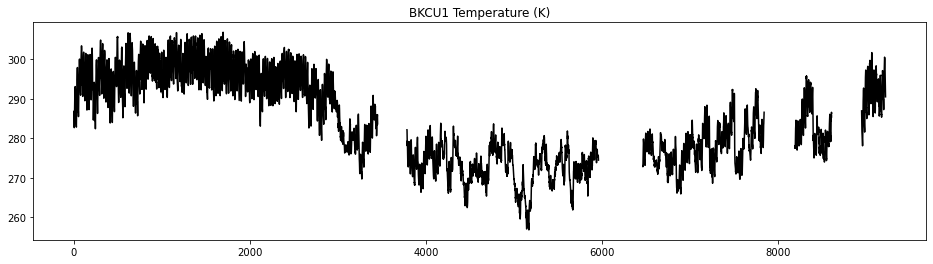

In [21]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(t2,linestyle='-',c='k',label='Temperature')
plt.title(station['STID'] + ' Temperature (K)')

Text(0.5, 1.0, 'BKCU1 Dew point (K)')

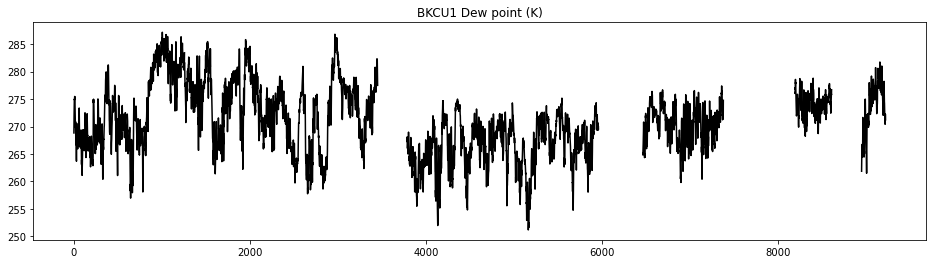

In [22]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(td,linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' Dew point (K)')

Text(0.5, 1.0, 'BKCU1 relative humidity (%)')

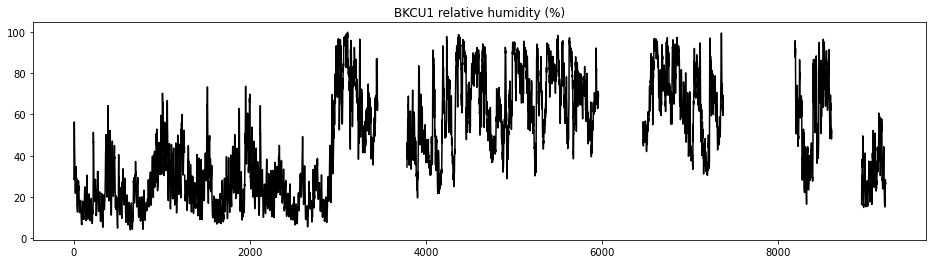

In [23]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rh,linestyle='-',c='k',label='Dew point')
plt.title(station['STID'] + ' relative humidity (%)')

Text(0.5, 1.0, 'BKCU1 drying and wetting equilibria (%)')

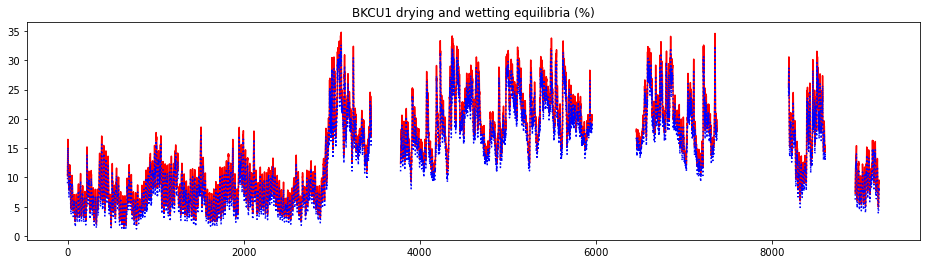

In [24]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(Ed,linestyle='-',c='r',label='drying equilibrium')
plt.plot(Ew,linestyle=':',c='b',label='wetting equilibrium')
plt.title(station['STID'] + ' drying and wetting equilibria (%)')

Text(0.5, 1.0, 'BKCU1 Precipitation')

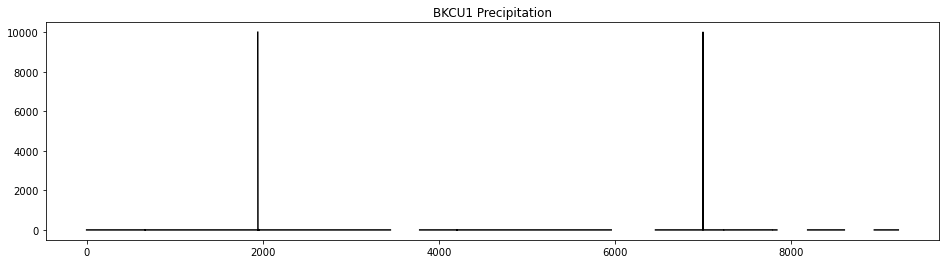

In [25]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rain,linestyle='-',c='k',label='Precipitation')
plt.title(station['STID'] + ' Precipitation' )

In [26]:
print(rain[1900:2000])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00            nan 9.99900000e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.11780963e-01 3.37612349e+00 7.65368785e-01 1.46232200e+01
 0.00000000e+00 3.63216038e-01 5.35815321e-03 0.00000000e+00
 5.81764222e-01 1.18612397e+01 2.05358153e-01 5.35815321e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

Precipitation from RTMA is in kg/m${}^2$. 1m water depth over 1m${}^2$ is 1m${}^3$ with mass 1000 kg thus 1 kg/m${}^2$ is the same as 1 mm of precipitation. RTMA values are accumulations over 1 h so these are values in mm/h. So 9999 mm/h = 10m/h makes no sense. Replace anything over 1m/h by nan and try again.

In [27]:
rain[rain > 1000] = np.NaN

Text(0.5, 1.0, 'BKCU1 Precipitation')

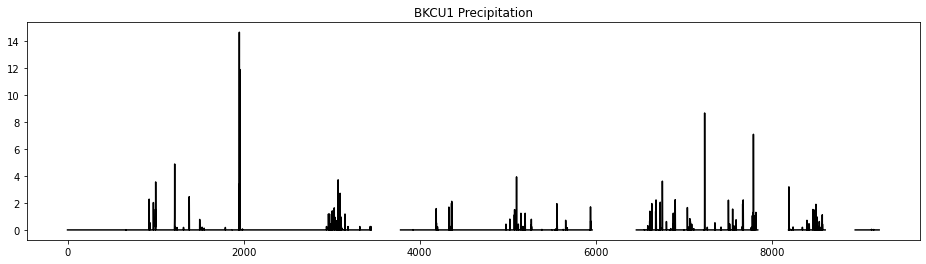

In [28]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(rain,linestyle='-',c='k',label='Precipitation')
plt.title(station['STID'] + ' Precipitation' )

Fix some missing data, then we can use the data for up to 1942 hours until a biger gap.

In [29]:
# fix isolated nans
def fixnan(a,n):
    for c in range(n):
        for i in np.where(np.isnan(a)):
            a[i]=0.5*(a[i-1]+a[i+1])
        if not any(np.isnan(a)):
            break
    return a

rain=fixnan(rain,2)
t2=fixnan(t2,2)
rh=fixnan(rh,2)
obs_data=fixnan(obs_data,2)
Ed=fixnan(Ed,2)
Ew=fixnan(Ew,2)

print(np.where(np.isnan(rain)))
print(np.where(np.isnan(t2)))
print(np.where(np.isnan(rh)))
print(np.where(np.isnan(obs_data)))

(array([1942, 1943, 3450, ..., 8942, 8943, 8944]),)
(array([3450, 3451, 3452, ..., 8942, 8943, 8944]),)
(array([3450, 3451, 3452, ..., 8942, 8943, 8944]),)
(array([], dtype=int64),)


In [30]:
### Define model function with drying, wetting, and rain equilibria

# Parameters
r0 = 0.05                                   # threshold rainfall [mm/h]
rk = 8.0                                    # saturation rain intensity [mm/h]
Trk = 14.0                                  # time constant for rain wetting model [h]
S = 2.5                                     # saturation intensity [dimensionless]
T = 10.0                                    # time constant for wetting/drying

def model_moisture(m0,Eqd,Eqw,r,partials=0):
    # arguments:
    # m0         starting fuel moistureb (1)
    # Eqd        drying equilibrium      (1) 
    # Eqw        wetting equilibrium     (1)
    # r          rain intensity          (mm/h)
    # partials = 0, 1, 2
    # returns: same as model_decay
    #   if partials==0: m1 = fuel moisture contents after time 1 hour
    #              ==1: m1, dm0/dm0 
    #              ==2: m1, dm1/dm0, dm1/dE   
    
    if r > r0:
        E = S
        T1 = 1.0 / (Trk * (1.0 - np.exp(- (r - r0) / rk)))
    elif m0 > Eqd:
        E = Eqd
        T1 = 1.0/T
    elif m0 < Eqw:
        E = Eqw
        T1 = 1.0/T
    else:
        E = m0     # should return m1 = m0, all partials zero
        T1 = 1.0   # does not matter
        
    # model_decay(m0,E,partials=0,T1=0.1,tlen=1):  # T1 = 1/T, partials 0=none, 1=dm0/dm1, 2=dm1/dm0, dm1/dE, dm1/dT1     
    return model_decay(m0,E,partials=partials,T1=T1,tlen=1)

# Kalman filter with RAWS observations, followed by forecasting
We run the model first with Kalman filter for 150 hours. The observations are the RAWS data
After 150 hours, we run in forecast mode - the RAWS data are no longer used, and we run the model from the weather data without the Kalman filter. The weather data are taken to be RTMA interpolated to one RAWS location.
In a real forecasting application, the model would be run from weather forecast rather than data.

In [31]:
# run KF on an initial data seqment
import numpy as np
import matplotlib.pyplot as plt 

hours=300
h2 = round(hours/2)
m = np.zeros(hours) # preallocate
m[0]= obs_data[0]             # initial state  
P = np.zeros(hours)
P[0] = 1e-3 # background state variance
H = np.array([1.])   # all oQ = np.array([0.02]) # process noise variancebserved
Q = np.array([1e-3]) # process noise variance
R = np.array([1e-3]) # data variance
for t in range(hours-1):
    # using lambda construction to pass additional arguments to the model 
    if t < h2 and not np.isnan(obs_data[t]) and not np.isnan(Ew[t]) and not np.isnan(rain[t]): # advance model and run KF
        m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_moisture(u,Ed[t],Ew[t],rain[t],partials=1),Q,
                    d=obs_data[t],H=H,R=R)
    else:  # just advance to next hour, no process noise
        m[t+1],P[t+1] = ext_kf(m[t],P[t],lambda u: model_moisture(u,Ed[t],Ew[t],rain[t],partials=1),Q*0.0)

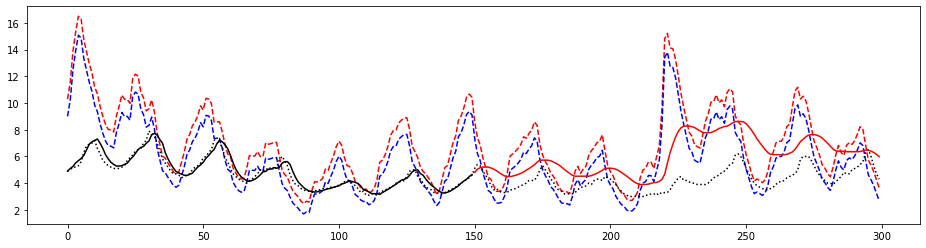

In [32]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(Ed[:hours],linestyle='--',c='r',label='Drying Equilibrium')
plt.plot(Ew[:hours],linestyle='--',c='b',label='Wetting Equilibrium')
plt.plot(obs_data[:hours],linestyle=':',c='k',label='RAWS data')
plt.plot(m[:h2],linestyle='-',c='k',label='filtered')
plt.plot(range(h2,hours),m[h2:hours],linestyle='-',c='r',label='forecast')

Let's check the state variance $P$. $P\to 0$ is a common problem in data assimilation, called filter degeneracy. With increasing cumulative amount of data, the variance of the state decreases and then the filter blindly follows the model. The underlying reason is that we trust that the model is accurate. This can work when nature and the model are the same system of equations, but here the nature is the nature and we need to recognize that the model is not accuratel. We guard against filter degeneracy by adding process noise $Q$ to the model. Ideally, the process noise variance  and the data noise variance should be about the same, then the assimilation will split the difference between the model uncertainly and the data uncertainty.

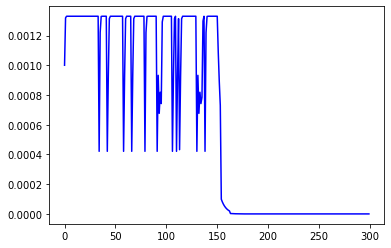

In [33]:
%matplotlib inline
plt.figure() # new figure
plt.plot(P,linestyle='-',c='b',label='Estimated state variance P')

Clearly, there is a problem - the forecast fuel moisture is too high. We need to assimilate also some parameters of the model, not just its state. 

## Model with an augmented state
In reality, the equilibrium moisture $E$ computed from atmospheric conditions
generally does not agree with the data. We want to add a correction $\Delta
E$ to $E$ constant in time, and identify the new parameter $\Delta E$ from data. 
Because the Kalman filter identifies state, add the parameter to the state.
Define augmented state $u=\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  .$ Since $\Delta E$ is constant in time, it satisfies the
differential equation $\frac{d\Delta E}{dt}=0.$ So, we want to estimate the
state $u$ governed by the
$$
\frac{d}{dt}\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
\frac{E+\Delta E-m(t)}{T}\\
0
\end{array}
\right]  ,
$$
which we write as $\frac{du}{dt}=F(u),$ where
$$
F(u)=\left[
\begin{array}
[c]{c}
F_{1}\left(  u\right)  \\
F_{2}\left(  u\right)
\end{array}
\right]  =F\left(  \left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  \right)  =\left[
\begin{array}
[c]{c}
\left(  E+\Delta E-m(t)\right)  T_{1}\\
0
\end{array}
\right]  ,\quad T_{1}=\frac{1}{T}.
$$
The Jacobian of $F$ is
$$
\left[
\begin{array}
[c]{cc}
\frac{\partial F_{1}}{\partial u_{1}} & \frac{\partial F_{1}}{\partial u_{2}
}\\
\frac{\partial F_{2}}{\partial u_{1}} & \frac{\partial F_{2}}{\partial u_{2}}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
\frac{\partial\Delta E}{\partial m_{0}} & \frac{\partial\Delta E}
{\partial\Delta E}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
0 & 1
\end{array}
\right]
$$
Here is a function that implements the augmented model $F$. The input is
$u_{0}$. The output is $u_{1}$ and the Jacobian $du_{1}/du_{0}$.

### Define augmented model function with drying, wetting, and rain equilibria

In [ ]:
def model_augmented(u0,Ed,Ew,r):
    # state u is the vector [m,dE] with dE correction to equilibria Ed and Ew
    # 
    m0, dE = u0  # decompose u0
    # reuse model_moisture(m0,Eqd,Eqw,r,partials=0):
    # arguments:
    # m0         starting fuel moistureb (1)
    # Eqd        drying equilibrium      (1) 
    # Eqw        wetting equilibrium     (1)
    # r          rain intensity          (mm/h)
    # partials = 0, 1, 2
    # returns: same as model_decay
    #   if partials==0: m1 = fuel moisture contents after time 1 hour
    #              ==1: m1, dm0/dm0 
    #              ==2: m1, dm1/dm0, dm1/dE 
    m1, dm1_dm0, dm1_dE  = model_moisture(m0,Ed + dE, Ew + dE, r, partials=2)
    u1 = np.array([m1,dE])   # dE is just copied
    J =  np.array([[dm1_dm0, dm1_dE],
                   [0.     ,     1.]])
    return u1, J

### Run the extended Kalman filter on the augmented model

In [48]:
u = np.zeros((2,hours))
u[:,0]=[0.1,0.1]       # initialize,background state  
P = np.zeros((2,2,hours))
P[:,:,0] = np.array([[0.005, 0.],
                    [0.,    0.005]]) # background state covariance
Q = np.array([[0.005, 0.],
              [0,  0.005]]) # process noise covariance
H = np.array([[1., 0.]])  # first component observed
R = np.array([0.005]) # data variance

# ext_kf(u,P,F,Q=0,d=None,H=None,R=None) returns ua, Pa

print('initial u=',u,'P=',P)
print('Q=',Q,'H=',H,'R=',R)
for t in range(1,h2):
    # use lambda construction to pass additional arguments to the model 
    u[:,t],P[:,:,t] = ext_kf(u[:,t-1],P[:,:,t-1],
                                 lambda uu: model_augmented(uu,Ed[t],Ew[t],rain[t]),
                                 Q,data[t],H=H,R=R)
for t in range(h2,hours):
    u[:,t+1],P[:,:,t] = ext_kf(u[:,t-1],P[:,:,t-1],
                                 lambda uu: model_augmented(uu,Ed[t],Ew[t],rain[t]),
                                 Q*0.0)
m = u[0,:]  # extract 
dE = u[1,:]

initial u= [[0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

time 137 obs data 3.2 Ed= [10.28432339 11.55194608 13.86825543 ...  9.55657813  8.9596754
  9.28135006] Ew= [ 8.99874245 10.22120102 12.47869626 ...  8.27232015  7.70164874
  8.01427789] rain= [0. 0. 0. ... 0. 0. 0.] filtered 0.1510077562253227
time 138 obs data 3.2 Ed= [10.28432339 11.55194608 13.86825543 ...  9.55657813  8.9596754
  9.28135006] Ew= [ 8.99874245 10.22120102 12.47869626 ...  8.27232015  7.70164874
  8.01427789] rain= [0. 0. 0. ... 0. 0. 0.] filtered 0.14893797534934675
time 139 obs data 3.3 Ed= [10.28432339 11.55194608 13.86825543 ...  9.55657813  8.9596754
  9.28135006] Ew= [ 8.99874245 10.22120102 12.47869626 ...  8.27232015  7.70164874
  8.01427789] rain= [0. 0. 0. ... 0. 0. 0.] filtered 0.17625418665590487
time 140 obs data 3.4 Ed= [10.28432339 11.55194608 13.86825543 ...  9.55657813  8.9596754
  9.28135006] Ew= [ 8.99874245 10.22120102 12.47869626 ...  8.27232015  7.70164874
  8.01427789] rain= [0. 0. 0. ... 0. 0. 0.] filtered 0.18151080369426317
time 141 obs data

time 226 obs data 4.5 Ed= [10.28432339 11.55194608 13.86825543 ...  9.55657813  8.9596754
  9.28135006] Ew= [ 8.99874245 10.22120102 12.47869626 ...  8.27232015  7.70164874
  8.01427789] rain= [0. 0. 0. ... 0. 0. 0.] forecast 6.517713334240117
time 227 obs data 4.2 Ed= [10.28432339 11.55194608 13.86825543 ...  9.55657813  8.9596754
  9.28135006] Ew= [ 8.99874245 10.22120102 12.47869626 ...  8.27232015  7.70164874
  8.01427789] rain= [0. 0. 0. ... 0. 0. 0.] forecast 2.360366372785667
time 228 obs data 4.2 Ed= [10.28432339 11.55194608 13.86825543 ...  9.55657813  8.9596754
  9.28135006] Ew= [ 8.99874245 10.22120102 12.47869626 ...  8.27232015  7.70164874
  8.01427789] rain= [0. 0. 0. ... 0. 0. 0.] forecast 6.695780621566859
time 229 obs data 4.1 Ed= [10.28432339 11.55194608 13.86825543 ...  9.55657813  8.9596754
  9.28135006] Ew= [ 8.99874245 10.22120102 12.47869626 ...  8.27232015  7.70164874
  8.01427789] rain= [0. 0. 0. ... 0. 0. 0.] forecast 2.4224251049043533
time 230 obs data 4.0 E

IndexError: index 300 is out of bounds for axis 1 with size 300

In [54]:
m,dE = u
print(m)
print(dE)


[ 0.1         0.59893109  0.80924634  0.9345595   1.00629512  1.03005545
  0.96432114  0.92760753  0.84946805  0.80717026  0.75518741  0.70877706
  0.64094565  0.60817597  0.56865722  0.53878422  0.53279353  0.51426911
  0.52630593  0.56840095  0.62549312  0.61381962  0.60632659  0.57897008
  0.64079713  0.6765052   0.70259504  0.64143895  0.60245262  0.52952936
  0.49430206  0.50579437  0.47008715  0.39533144  0.35068233  0.32028313
  0.30187584  0.29145951  0.27801922  0.25098241  0.25057484  0.24662727
  0.27709277  0.27984024  0.33556143  0.3410236   0.37849376  0.39957274
  0.41328775  0.46154668  0.44291143  0.4687778   0.46362583  0.46213625
  0.36382686  0.34929284  0.32452704  0.31859176  0.2704411   0.23378799
  0.22446393  0.2162942   0.18559208  0.18977056  0.19257287  0.17516043
  0.19463354  0.22637095  0.22038302  0.20707247  0.21538125  0.20434589
  0.20747477  0.24716914  0.22627984  0.23096324  0.22415147  0.2157805
  0.16914615  0.12230395  0.107475    0.09893534  0.

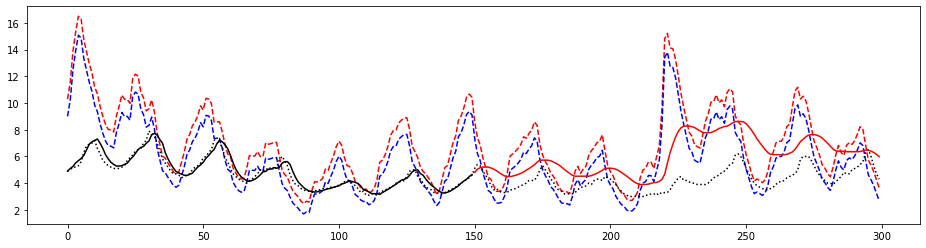

In [49]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(Ed[:hours],linestyle='--',c='r',label='Drying Equilibrium')
plt.plot(Ew[:hours],linestyle='--',c='b',label='Wetting Equilibrium')
plt.plot(obs_data[:hours],linestyle=':',c='k',label='RAWS data')
plt.plot(m[:h2],linestyle='-',c='k',label='filtered')
plt.plot(range(h2,hours),m[h2:hours],linestyle='-',c='r',label='forecast')



In [ ]:
DeltaE

In [ ]:
d=np.array([])
if d:
  print('yes')

In [ ]:
for d in range(24):
  print(d)

# With real data

In [ ]:
! pip install intergrid
from intergrid.intergrid import Intergrid  # docs https://pypi.org/project/intergrid/
from datetime import date
import pandas as pd
start_date = date(2018,5,19)
end_date = date(2020,6,1)
for d in pd.date_range(start_date,end_date,freq="1h"):
    path = d.strftime("%Y%m%d/%H")
    print(path)

#Experiments

In [ ]:
import numpy as np
a = np.array([1.])
b = np.array([2.])
c  = a @ b
print('a',a)
print('b',b)
print('c=a@b',c)

# Testers

In [ ]:
# a basic ext_kf test
import numpy as np
u = [1,
     2]
P = [[2 , -1],
    [-1 , 2]]
A = [ [1 ,2],
      [3 ,4]]
u = np.array(u)      
Q = np.array([[1,0],[0,1]])
A = np.array(A)
def fun(u):
  return A @ u, A
F = lambda u: fun(u)
H = [[1, 0],
     [0, 1]]
d = [2,
    3]
R = [[2, 0],
    [0, 2]]
H = np.array(H)      
d = np.array(d)
R = np.array(R)
ua,Pa = ext_kf(u,P,F,Q)
print('ua=',ua)
print('Pa=',Pa)
ua,Pa = ext_kf(u,P,F,Q,d,H,R)
print('ua=',ua)
print('Pa=',Pa)


First try to approximate Ed Ew by ML following https://www.tensorflow.org/guide/keras/sequential_model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import pyplot as plt

First ML following 
first simple example following https://machinelearningmastery.com/neural-networks-are-function-approximators/
We want to find approximate the function that maps (t2,rh) to (Ew,Ed)

In [ ]:
# Define Sequential model with 3 layers
model = keras.Sequential()
model.add(keras.Input(shape=(2,)))
model.add(layers.Dense(2, activation="sigmoid", name="layer1"))
model.add(layers.Dense(3, activation="sigmoid", name="layer2"))
model.add(layers.Dense(2, name="layer3"))  # alone just linear regression
model.summary()
model.compile(optimizer='adam',loss='mse')

In [ ]:
# select and separately scale the input and output variables
sz=500
train=250
t2s=t2[:sz].reshape(-1,1)
rhs=rh[:sz].reshape(-1,1)
Eds=Ed[:sz].reshape(-1,1)
Ews=Ew[:sz].reshape(-1,1)
print(t2s.shape,rhs.shape,Eds.shape,Ews.shape)
print(min(t2s),max(t2s),min(rhs),max(rhs),min(Eds),max(Eds),min(Ews),max(Ews))
scale_t2 = MinMaxScaler()
t2_scaled = scale_t2.fit_transform(t2s)
scale_rh = MinMaxScaler()
rh_scaled = scale_rh.fit_transform(rhs)
scale_Ed = MinMaxScaler()
Ed_scaled = scale_Ed.fit_transform(Eds)
scale_Ew = MinMaxScaler()
Ew_scaled = scale_Ew.fit_transform(Ews)
print(t2_scaled.shape,rh_scaled.shape,Ed_scaled.shape,Ew_scaled.shape)
print(min(t2_scaled),max(t2_scaled),min(rh_scaled),max(rh_scaled),
      min(Ed_scaled),max(Ed_scaled),min(Ew_scaled),max(Ew_scaled))
x=np.concatenate([t2_scaled,rh_scaled],axis=1)
y=np.concatenate([Ed_scaled,Ew_scaled],axis=1)
print(x.shape,y.shape)

In [ ]:
model.fit(x[:,:train], y[:,:train], epochs=500, batch_size=10, verbose=0)
print('done')

In [ ]:
# evaluate the model
y_pred = model.predict(x)
# inverse transforms
print(y_pred.shape)
Ed_pred = scale_Ed.inverse_transform(y_pred[:,0].reshape(-1, 1))
Ew_pred = scale_Ew.inverse_transform(y_pred[:,1].reshape(-1, 1))
print(Ed_pred.shape,Ew_pred.shape)
# report model error
print('Ed min max:',min(Eds),max(Eds),'diff',max(Eds)-min(Eds) )
print('Ed MSE on training data:   %.3f' % mean_squared_error(Eds[:train], Ed_pred[:train]))
print('Ed MSE on validation data: %.3f' % mean_squared_error(Eds[train:], Ed_pred[train:]))
print('Ew min max:',min(Ews),max(Ews),'diff',max(Ews)-min(Ews) )
print('Ew MSE on training data:   %.3f' % mean_squared_error(Ews[:train], Ew_pred[:train]))
print('Ew MSE on validation data: %.3f' % mean_squared_error(Ews[train:], Ew_pred[train:]))


Get data (labels) 

In [ ]:
obs = obs_data[:sz].reshape(-1,1)
scale_obs = MinMaxScaler()
obs_scaled = scale_obs.fit_transform(Eds)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential()
# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128,input_shape=(3,))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()